# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta'))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}\sum_{i\in\bf{\theta}_0}\log g(x_i)+\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})+\sum_{i\in\bf{\theta}}(f(x_{T,i},\theta')/(1-f(x_{T,i},\theta')))\log (1-g(x_{D,i}))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback
import keras.backend as K
import keras 

# Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

In [30]:
N = 1000000
theta0_param = 0 #this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1 #this is the data (the target)

theta0 = np.random.normal(theta0_param,1,N)
theta1 = np.random.normal(theta1_param,1,N)
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0,theta1])
yvals = np.concatenate([labels0,labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0.5)

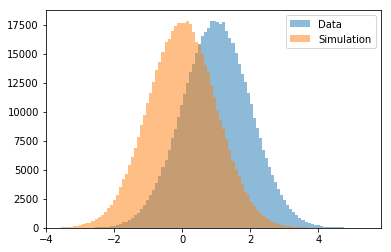

In [31]:
n, bins, patches=plt.hist(X_train[y_train==1],bins=100,alpha=0.5,label="Data")
_=plt.hist(X_train[y_train==0],bins=bins,alpha=0.5,label="Simulation")
plt.legend()

# Weight Model

Let's show that the reweighting works by training a DCTR model.

In [84]:
theta_min = -2
theta_max = 2

theta_many = np.random.uniform(theta_min,theta_max,N)
vals_many = np.random.normal(theta_many,1,N)
simulation = list(zip(vals_many,theta_many))

vals_target = np.random.normal(theta1_param,1,N)
data = list(zip(vals_target,theta_many))

In [85]:
model_weight = Sequential()
model_weight.add(Dense(20, input_dim=2, activation='relu'))
model_weight.add(Dense(40, activation='relu'))
model_weight.add(Dense(1, activation='sigmoid'))

In [86]:
data_labels = np.ones(len(data))
simulation_labels = np.zeros(len(simulation))
X = np.concatenate((data, simulation))
Y = np.concatenate((data_labels, simulation_labels))
X_train_weight, X_test_weight, Y_train_weight, Y_test_weight = train_test_split(X, Y, test_size=0.5)

In [87]:
model_weight.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
model_weight.fit(X_train_weight, Y_train_weight, epochs=3, batch_size=5000)

Epoch 1/3
1000000/1000000 [==============================] - 3s 3us/step - loss: 0.5457 - acc: 0.6916
Epoch 2/3
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5124 - acc: 0.7114
Epoch 3/3
1000000/1000000 [==============================] - 2s 2us/step - loss: 0.5101 - acc: 0.7138


In [38]:
exact_weights = np.exp(-0.5*(theta0-theta1_param)**2+0.5*(theta0-theta0_param)**2)

In [89]:
pred_input = np.array(list(zip(theta0,theta0_param*np.ones(len(theta0)))))
preds = model_weight.predict(pred_input)

In [90]:
pred_weights = preds/(1.-preds)

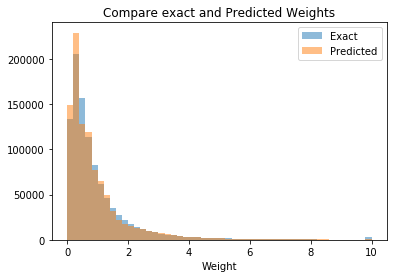

In [91]:
bins = np.linspace(0,10,51)
plt.hist(np.clip(exact_weights, bins[0], bins[-1]), bins=bins, alpha=0.5, label='Exact')
plt.hist(np.clip(pred_weights, bins[0], bins[-1]), bins=bins, alpha=0.5, label='Predicted')
plt.title("Compare exact and Predicted Weights")
plt.legend(loc=1)
plt.xlabel("Weight")
plt.show()

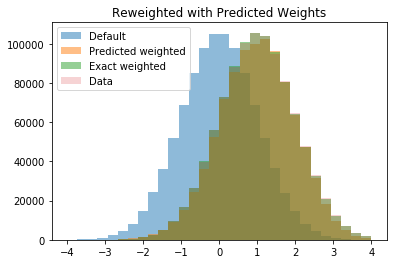

In [92]:
bins = np.linspace(-4,4,31)
plt.hist(theta0, bins = bins, alpha=0.5, label='Default')
plt.hist(theta0, bins = bins, alpha=0.5, weights=pred_weights,label='Predicted weighted')
plt.hist(theta0, bins = bins, alpha=0.5, weights=exact_weights,label='Exact weighted')
plt.hist(theta1, bins = bins, alpha=0.2, label='Data')
plt.legend(loc=0)
plt.title("Reweighted with Predicted Weights")
plt.show()

Now, for the fitting part, let's factorize the problem and assume we already have a good DCTR model.  In this Gaussian case, we know the right answer so we can just use the exact reweighting instead of the NN one.

# Fitting Model

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

In [94]:
K.clear_session()

myinputs = Input(shape=(1,))

x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
#model.summary()

def my_loss_wrapper(inputs,val=0.0):
    x  = inputs #[:,1:]
    theta = 0. #starting value
    theta0 = val #target value
    weight = K.exp(-(0.5*(x-theta0)**2)+(0.5*(x-theta)**2))
    def my_loss(y_true,y_pred):
        t_loss = y_true*(y_true - y_pred)**2+(weight**2)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
    return my_loss

In [100]:
thetas = np.linspace(0,2,5)
lvals = []
for theta in thetas:
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, epochs=1, batch_size=500,validation_data=(np.array(X_test), y_test),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
print(lvals) 

Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.1989 - acc: 0.6914 - val_loss: 0.1990 - val_acc: 0.6916
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.2821 - acc: 0.5070 - val_loss: 0.2808 - val_acc: 0.5003
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.3045 - acc: 0.3199 - val_loss: 0.3010 - val_acc: 0.3081
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.2698 - acc: 0.3193 - val_loss: 0.2694 - val_acc: 0.3238
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.2222 - acc: 0.3432 - val_loss: 0.2222 - val_acc: 0.3477
[[0.19897835393995048], [

Text(0,0.5,'Loss')

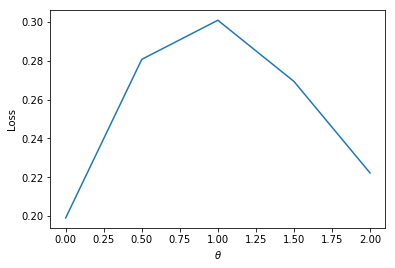

In [102]:
plt.plot(thetas,lvals)
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

In [108]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(". theta fit = ",model.layers[-1].get_weights()[-1]))

In [109]:
K.clear_session()

myinputs = Input(shape=(1,))
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
identity = Lambda(lambda x: x + 0)(predictions)    
model = Model(inputs=myinputs, outputs=identity)
model.layers[np.size(model.layers)-1].add_weight(name="thetaX",shape=list(),initializer = keras.initializers.Constant(1.5),trainable=True)

def my_loss_wrapper(inputs,mysign = 1):
    x  = inputs
    theta = 0. #starting value
    theta0 = tf.get_default_graph().get_tensor_by_name("thetaX:0")
    # Exact weight:
    weight = K.exp(-(0.5*(x-theta0)**2)+(0.5*(x-theta)**2))
    def my_loss(y_true,y_pred):
        t_loss = mysign*(y_true*(y_true - y_pred)**2+weight*(1.-y_true)*(y_true - y_pred)**2)
        return K.mean(t_loss)
    return my_loss
    
for k in range(10):    
    
    for i in range(len(model.layers)-1):
        model.layers[i].trainable = True
        pass    
    model.layers[-1].trainable = False
    #model.summary()    
    
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,1),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, epochs=1, batch_size=10000,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=[print_weights])

    #Now, fix g and train \theta.

    for i in range(len(model.layers)-1):
        model.layers[i].trainable = False
        pass    
    model.layers[-1].trainable = True
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,-1),metrics=['accuracy'])
    #model.summary()
    
    model.fit(np.array(X_train), y_train, epochs=1, batch_size=10000,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=[print_weights])    
    pass

Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 5s 5us/step - loss: 0.2370 - acc: 0.3447 - val_loss: 0.2356 - val_acc: 0.3367
. theta fit =  1.5
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 3s 3us/step - loss: -0.2386 - acc: 0.3369 - val_loss: -0.2415 - val_acc: 0.3367
. theta fit =  1.3995681
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 5s 5us/step - loss: 0.2406 - acc: 0.3487 - val_loss: 0.2406 - val_acc: 0.3322
. theta fit =  1.3995681
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 3s 3us/step - loss: -0.2432 - acc: 0.3322 - val_loss: -0.2456 - val_acc: 0.3322
. theta fit =  1.299317
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 7s 7us/step - lo